# HYFN Capstone Project 
## --- Prediction of website clicks in advertisement campaign

### Part 1: Data preparation

In this project, I am using the PostgreSQL interface in Python to access the database on cluster. Since I am focusing on the modeling of campaign level, the table I am interested are :  
1. facebook_daily_campaign_stats  
2. fb_ads_campaign_groups
3. fb_ads_accounts

Table 1 and 2 are first joined by column "campaign_id", the combined table are then joined with table 3 by column "account_id". 

In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta, date
import matplotlib.dates as mdates

In [2]:
fb_daily_campaign_stats_df = pd.read_csv('fb_daily_campaign_stats')
fb_campaign_groups_df = pd.read_csv('fb_campaign_groups')
fb_ads_accounts_df = pd.read_csv('fb_ads_accounts')

In [3]:
stats_group_merge = pd.merge(fb_daily_campaign_stats_df,fb_campaign_groups_df[['service_id','objective','account_id']], how = 'left', left_on = 'campaign_id', right_on = 'service_id')

In [4]:
all_merge = pd.merge(stats_group_merge, fb_ads_accounts_df[['id','name','account_id']], how = 'left', left_on = 'account_id', right_on = 'id')

In [5]:
fb_campaign_df = all_merge

** Table summaries**  
The table "fb_daily_campaign_stats" has 46829 rows in total. However, only 20786 ones have valid "account_id" and associated "objective" after joining.   
We will also only look at the campaign records with objective "LINK_CLICKS", since our aim is to model the relationship between "spend" and "website click". Ad campaign with other objectives may have significantly non-proportional relation between these two variables. The final data point is 6865.  

Example of final data table is named "fb_link_df" and sample rows are also given below.

In [11]:
select_cols = ['account_id_y','name','campaign_id','date_start','spend','inline_link_clicks','objective']
fb_df = fb_campaign_df[select_cols]
fb_df.columns = ['account_id','name','campaign_id','date_start','spend','link_clicks','objective']
fb_link_df = fb_df[fb_df.objective == 'LINK_CLICKS']

In [13]:
# Convert account_id & campaign_id to string
temp = ['{:.0f}'.format(x) for x in fb_link_df.campaign_id]
fb_link_df.loc[fb_link_df.index,'campaign_id'] = temp
temp = ['{:.0f}'.format(x) for x in fb_link_df.account_id]
fb_link_df.loc[fb_link_df.index,'account_id'] = temp

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
fb_link_df = fb_link_df[fb_link_df.spend > 1.0]
fb_link_df = fb_link_df[fb_link_df.link_clicks > 1.0]

In [20]:
fb_link_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 0 to 46981
Data columns (total 7 columns):
account_id     6571 non-null object
name           6571 non-null object
campaign_id    6571 non-null object
date_start     6571 non-null object
spend          6571 non-null float64
link_clicks    6571 non-null float64
objective      6571 non-null object
dtypes: float64(2), object(5)
memory usage: 410.7+ KB


** Sample table content:**

In [21]:
fb_link_df.head(5)

,account_id,name,campaign_id,date_start,spend,link_clicks,objective
0,1012201575494245,Target,6047406179103,2016-05-18,60.55,15.0,LINK_CLICKS
50,345009516,All Clients - LIN Digital,6051253714720,2016-09-20,16.67,52.0,LINK_CLICKS
51,345009516,All Clients - LIN Digital,6049742187920,2016-09-20,50.32,22.0,LINK_CLICKS
53,345009516,All Clients - LIN Digital,6047731536920,2016-09-20,14.39,51.0,LINK_CLICKS
54,345009516,All Clients - LIN Digital,6046540842520,2016-09-20,11.93,9.0,LINK_CLICKS


**Table summary:**

In [22]:
num_account = fb_link_df.account_id.value_counts().shape
num_campaign = fb_link_df.campaign_id.value_counts().shape

print 'Total number of account : %i\nTotal number of campaign: %i' %(num_account[0], num_campaign[0])
print 'The time frame is from %s to %s' %(min(fb_link_df.date_start),max(fb_link_df.date_start))

Total number of account : 32
Total number of campaign: 192
The time frame is from 2016-04-18 to 2016-12-20


** Add in vertical information **

In [23]:
account_vertical_df = pd.read_csv('Hyfn_account_vertical_key.csv')

In [24]:
temp = ['{:.0f}'.format(x) for x in account_vertical_df.account_id]
account_vertical_df.loc[account_vertical_df.index,'account_id'] = temp

In [25]:
account_vertical_df.head()

,name,account_id,vertical,vertical2
0,Usher Security,1011716032209460,Internet Company,Workplace & Office
1,Gogobot,1003305413050520,Travel,NaN
2,QuikTrip,1012680412113020,Convenience Store,NaN
3,Ashford University,1017974154916980,Education,Lead Gen
4,Visit California,868189209895483,Travel,NaN


In [26]:
fb_link_df = pd.merge(fb_link_df, account_vertical_df[['account_id','vertical','vertical2']], how = 'left', left_on = 'account_id', right_on = 'account_id')

In [28]:
fb_link_df.sort_values(['account_id','campaign_id','date_start'], inplace = True)

Transform "spend" and "inline_link_clicks" into logrithmic scale

In [29]:
fb_link_df.loc[fb_link_df.index,'log_spend'] = np.log(fb_link_df.spend)
fb_link_df.loc[fb_link_df.index,'log_click'] = np.log(fb_link_df.link_clicks)

In [30]:
fb_link_df.drop(['spend','link_clicks'], axis = 1, inplace = True)

In [31]:
fb_link_df.head()

,account_id,name,campaign_id,date_start,objective,vertical,vertical2,log_spend,log_click
1234,1003374119710324,Line Tale 2,6042354718738,2016-04-18,LINK_CLICKS,NaN,NaN,5.587099,3.951244
22,1003374119710324,Line Tale 2,6042354718738,2016-04-19,LINK_CLICKS,NaN,NaN,7.921623,6.408529
60,1003374119710324,Line Tale 2,6042354718738,2016-04-20,LINK_CLICKS,NaN,NaN,7.666882,6.437752
815,1003374119710324,Line Tale 2,6042354718738,2016-04-21,LINK_CLICKS,NaN,NaN,7.551801,6.656727
267,1003374119710324,Line Tale 2,6042354718738,2016-04-22,LINK_CLICKS,NaN,NaN,7.431779,6.659294


**fb_link_df** is the original complete dataset

In [33]:
fb_link_df.describe()

,log_spend,log_click
count,6571.000000,6571.000000
mean,3.595834,3.867835
std,1.297067,1.646679
min,0.307485,0.693147
25%,2.751429,2.708050
50%,3.391147,3.610918
75%,4.356452,4.894094
max,9.402295,10.617564


### Part 2: Data modeling 
### 2.1 Ex post model

1.Convert "campaign_id" into category data(dummy variables)

In [34]:
expost_ml_df = pd.concat([fb_link_df, pd.get_dummies(fb_link_df.campaign_id,drop_first=True)], axis = 1)

2.Drop the redundant columns

In [35]:
expost_ml_df.drop(['account_id','campaign_id','date_start','objective','name','vertical','vertical2'], axis = 1, inplace = True)

Data Frame "link_ml_df" ready for machine learning

In [36]:
expost_ml_df.reset_index(drop = True, inplace = True)

In [38]:
expost_ml_df.head()

,log_spend,log_click,23842505131670744,23842505131810744,23842505131840744,23842505782680160,23842506958430736,23842507000030736,23842507560460492,23842508340700492,...,6063174510444,6063972989165,6064002893844,6064003490044,6064004160044,6064663893217,6064969908417,6064970231017,6066725507025,6067165333617
0,5.587099,3.951244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.921623,6.408529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.666882,6.437752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.551801,6.656727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.431779,6.659294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Regression Model :

\begin{equation*}
log(Clicks) = m* log(spend)+b_{campaign}+b_{int}
\end{equation*}

In this project, I am going to use the ski-learn(ML package built in Python) for various regression problems.

In [39]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import metrics

linreg = linear_model.LinearRegression(fit_intercept=True)  # This is the default
X = expost_ml_df.copy()
X.drop('log_click', axis = 1, inplace = True)
y = expost_ml_df.log_click
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Spend coefficients**:

In [42]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg.coef_[0]

The spend coefficients between log(spend) and log(clicks) (m) is 0.96


**In-sample prediction metric**:

In [43]:
print "The in-sample prediction R^2 is %.4f" % linreg.score(X,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg.predict(X))

The in-sample prediction R^2 is 0.9491
The mean squared error in model is 0.1379


**Visualization**

In [44]:
x0 = X.loc[X.index[0]] 
X0 = pd.DataFrame({}, columns = X.columns)
X0 = X0.append([x0]*50,ignore_index=True)
X0['log_spend'] = pd.Series(np.linspace(0, 10, 50))

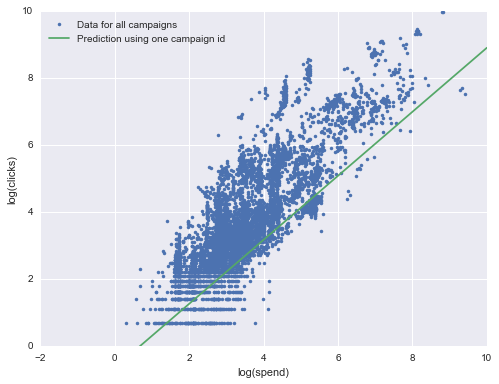

In [45]:
plt.figure(figsize=(8,6))
plt.plot(X.log_spend, y, '.')
plt.plot(X0.log_spend, linreg.predict(X0), '-')
plt.xlabel('log(spend)')
plt.ylabel('log(clicks)')
plt.axis([-2, 10, 0, 10])
plt.legend(['Data for all campaigns','Prediction using one campaign id'],loc='best')

**Coefficients of Regression model (variation in campaigns $b_{campaign}$)** 

In [46]:
coeffs = linreg.coef_[1:]
len(coeffs)

191

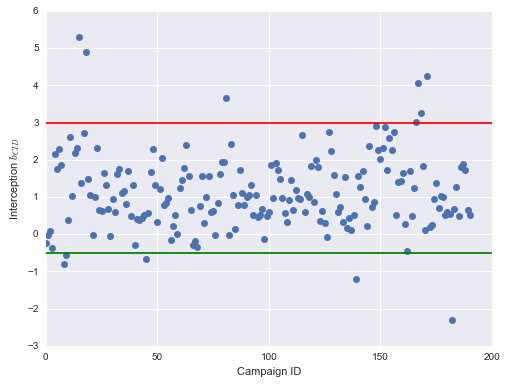

In [52]:
plt.figure(figsize=(8,6))
plt.plot(coeffs,'o')
plt.xlabel('Campaign ID')
plt.ylabel('Interception $b_{CID}$')
plt.axhline(y=3, color = 'r')
plt.axhline(y=-0.5, color = 'g')
#plt.axis([0, 12, -2, 6])

Now, we can compare the effectiveness of various campaign. From the plot, it seems most of the campaign are close and around similar values . However, there are some outliers as well. It may be interesting to look at those campaign individually and see what are the reasons for these differences.

In [53]:
coeffs_group1 = X.columns[1:][coeffs > 3]
coeffs_group2 = X.columns[1:][coeffs < -0.5]

In [54]:
coeffs_group1_name = list()
for id in coeffs_group1:
    company_name = fb_link_df[fb_link_df.campaign_id == str(id)].name
    coeffs_group1_name.append(company_name.values[0])
    
coeffs_group1_name

['Olympics',
 'Olympics',
 'Visit California',
 'Micro Strategy',
 'Micro Strategy',
 'Micro Strategy',
 'Micro Strategy']

In [55]:
coeffs_group2_name = list()
for id in coeffs_group2:
    company_name = fb_link_df[fb_link_df.campaign_id == str(id)].name
    coeffs_group2_name.append(company_name.values[0])
    
coeffs_group2_name

['Chime',
 'Chime',
 'Target',
 'TrueCar Main: 106471106226037',
 'TrueCar Main: 106471106226037']

Before building the ex ante model, we can also do a cross-validation on our current model to evaluate its ability.

### 2.2 Ex ante model

From previous analysis, it is found that there is a nice linear relationship between the log_spend and log_click within each campaign. If the characteristics of a provided campaign are properly captured, we can predict the future pay back ratio (click/spend).

### 2.2.1  Model  1 (Baseline) :

\begin{equation*}
log(Clicks) = m* log(spend)+b_{int}
\end{equation*}

In [56]:
X_base = fb_link_df.log_spend.reshape(-1,1)
y = fb_link_df.log_click

In [57]:
linreg_base = linear_model.LinearRegression(fit_intercept=True)
linreg_base.fit(X_base,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [58]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg_base.coef_[-1]
print "The in-sample prediction R^2 is %.4f" % linreg_base.score(X_base,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg_base.predict(X_base))

The spend coefficients between log(spend) and log(clicks) (m) is 1.04
The in-sample prediction R^2 is 0.6769
The mean squared error in model is 0.8759


### 2.2.2  Model 2: (Baseline + Vertical):

\begin{equation*}
log(Clicks) = m* log(spend)+b_{int}+b_{vert}
\end{equation*}

In [60]:
fb_link_df.vertical.fillna(value = 'Unknown1', inplace = True)
fb_link_df.vertical2.fillna(value = 'Unknown2', inplace = True)

In [61]:
fb_link_df.head()

,account_id,name,campaign_id,date_start,objective,vertical,vertical2,log_spend,log_click
1234,1003374119710324,Line Tale 2,6042354718738,2016-04-18,LINK_CLICKS,Unknown1,Unknown2,5.587099,3.951244
22,1003374119710324,Line Tale 2,6042354718738,2016-04-19,LINK_CLICKS,Unknown1,Unknown2,7.921623,6.408529
60,1003374119710324,Line Tale 2,6042354718738,2016-04-20,LINK_CLICKS,Unknown1,Unknown2,7.666882,6.437752
815,1003374119710324,Line Tale 2,6042354718738,2016-04-21,LINK_CLICKS,Unknown1,Unknown2,7.551801,6.656727
267,1003374119710324,Line Tale 2,6042354718738,2016-04-22,LINK_CLICKS,Unknown1,Unknown2,7.431779,6.659294


In [62]:
ml_vert_df = fb_link_df[['log_spend','log_click','vertical','vertical2']]

In [63]:
ml_vert_df = pd.concat([ml_vert_df, pd.get_dummies(ml_vert_df.vertical,drop_first=True),pd.get_dummies(ml_vert_df.vertical2,drop_first=True)], axis = 1)

In [64]:
[ml_vert_df.vertical.value_counts().index,ml_vert_df.vertical2.value_counts().index]

[Index([u'Unknown1', u'Internet Company', u'Travel', u'Health Care', u'Retail',
        u'Pregnancy', u'Entertainment', u'Non-Profit', u'QSR', u'Automotive',
        u'Technology', u'Public Health', u'Advertising'],
       dtype='object'),
 Index([u'Unknown2', u'Workplace & Office', u'Lead Gen', u'Apparel', u'CPG',
        u'Health', u'Movie', u'Seniors', u'Loan'],
       dtype='object')]

In [66]:
ml_vert_df.drop(['vertical','vertical2'], axis =1, inplace = True)

In [67]:
ml_vert_df.columns

Index([u'log_spend', u'log_click', u'Automotive', u'Entertainment',
       u'Health Care', u'Internet Company', u'Non-Profit', u'Pregnancy',
       u'Public Health', u'QSR', u'Retail', u'Technology', u'Travel',
       u'Unknown1', u'CPG', u'Health', u'Lead Gen', u'Loan', u'Movie',
       u'Seniors', u'Unknown2', u'Workplace & Office'],
      dtype='object')

In [68]:
ml_vert_df.head()

,log_spend,log_click,Automotive,Entertainment,Health Care,Internet Company,Non-Profit,Pregnancy,Public Health,QSR,...,Travel,Unknown1,CPG,Health,Lead Gen,Loan,Movie,Seniors,Unknown2,Workplace & Office
1234,5.587099,3.951244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,7.921623,6.408529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
60,7.666882,6.437752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
815,7.551801,6.656727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
267,7.431779,6.659294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
linreg_vert = linear_model.LinearRegression(fit_intercept=True)  # This is the default
X_vert = ml_vert_df.copy()
X_vert.drop('log_click', axis = 1, inplace = True)
y = ml_vert_df.log_click
linreg_vert.fit(X_vert, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
X_vert.head()

,log_spend,Automotive,Entertainment,Health Care,Internet Company,Non-Profit,Pregnancy,Public Health,QSR,Retail,...,Travel,Unknown1,CPG,Health,Lead Gen,Loan,Movie,Seniors,Unknown2,Workplace & Office
1234,5.587099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,7.921623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
60,7.666882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
815,7.551801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
267,7.431779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [72]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg_vert.coef_[0]
print "The in-sample prediction R^2 is %.4f" % linreg_vert.score(X_vert,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg_vert.predict(X_vert))

The spend coefficients between log(spend) and log(clicks) (m) is 1.09
The in-sample prediction R^2 is 0.7341
The mean squared error in model is 0.7210


In [73]:
X_vert_only = X_vert.copy()

In [74]:
X_vert_only.drop(['log_spend'], axis = 1, inplace = True)

In [75]:
X_vert_only.sum(axis = 1).value_counts()

2.0    6418
1.0     153
dtype: int64

### 2.2.3 Model 3: (Baseline + vertical + time features) 
#### aggregate analysis 

This is to find the probable related time features

In [77]:
temp = [datetime.strptime(x,"%Y-%m-%d") for x in fb_link_df.date_start]
fb_link_df.loc[fb_link_df.index,'date_start'] = temp

Parse the month, weekday and week for each campaign

In [78]:
month =[ x.date().month for x in fb_link_df.date_start]
weekday =[ x.date().weekday() for x in fb_link_df.date_start]
week = [ x.date().isocalendar()[1] for x in fb_link_df.date_start]

fb_link_df.loc[fb_link_df.index,'month'] = month
fb_link_df.loc[fb_link_df.index,'weekday'] = weekday
fb_link_df.loc[fb_link_df.index,'week'] = week

Weekday_dict = { 0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5:'Sat', 6:'Sun'}
Month_dict = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov',12: 'Dec'}
fb_link_df['month'] = fb_link_df['month'].map(Month_dict)
fb_link_df['weekday'] = fb_link_df['weekday'].map(Weekday_dict)

In [79]:
import seaborn as sns

**Monthly Feature**

In [82]:
vert1_mon_df = fb_link_df.groupby(['vertical','month']).mean().reindex(['Apr','Jun','Jul','Sep','Oct','Nov','Dec'],level = 1)
vert2_mon_df = fb_link_df.groupby(['vertical2','month']).mean().reindex(['Apr','Jun','Jul','Sep','Oct','Nov','Dec'],level = 1)

vert_mon_df = pd.concat([vert1_mon_df,vert2_mon_df], axis = 0)

In [86]:
ver_mon_spend_df = vert_mon_df['log_spend'].unstack()
ver_mon_click_df = vert_mon_df['log_click'].unstack()
ver_mon_ratio_df = ver_mon_click_df/ver_mon_spend_df

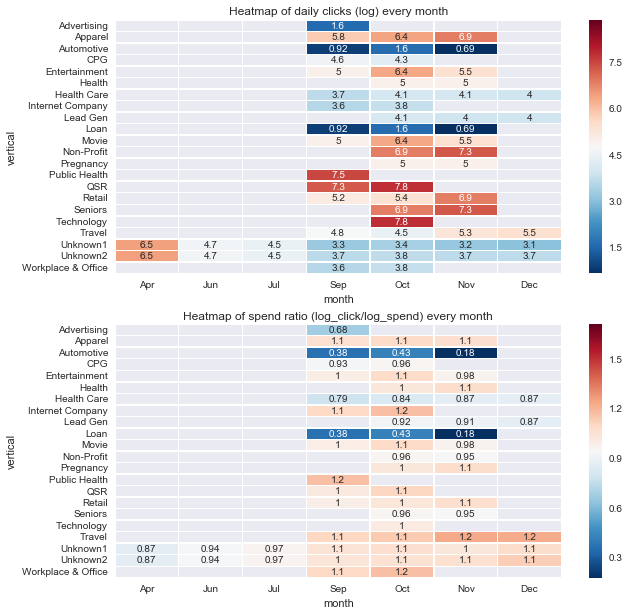

In [97]:
ver_mon_spend_df = ver_mon_spend_df[['Apr','Jun','Jul','Sep','Oct','Nov','Dec']]
ver_mon_click_df = ver_mon_click_df[['Apr','Jun','Jul','Sep','Oct','Nov','Dec']]
ver_mon_ratio_df = ver_mon_ratio_df[['Apr','Jun','Jul','Sep','Oct','Nov','Dec']]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#sns.heatmap(ver_mon_spend_df,annot = True, linewidths=.5, cbar = True, ax = ax1)
sns.heatmap(ver_mon_click_df,annot = True, linewidths=.5, cbar = True, center = ver_mon_click_df.mean().mean(), ax = ax1)
ax1.set_title('Heatmap of daily clicks (log) every month')
sns.heatmap(ver_mon_ratio_df,annot = True, linewidths=.5, cbar = True, center = ver_mon_ratio_df.mean().mean(), ax = ax2)
ax2.set_title('Heatmap of daily spend ratio (log_click/log_spend) every month')

** Weekday feature**

In [98]:
vert1_weekday_df = fb_link_df.groupby(['vertical','weekday']).mean()
vert2_weekday_df = fb_link_df.groupby(['vertical2','weekday']).mean()

vert_weekday_df = pd.concat([vert1_weekday_df,vert2_weekday_df], axis = 0)

In [99]:
ver_weekday_spend_df = vert_weekday_df['log_spend'].unstack()
ver_weekday_click_df = vert_weekday_df['log_click'].unstack()
ver_weekday_ratio_df = ver_weekday_click_df/ver_weekday_spend_df

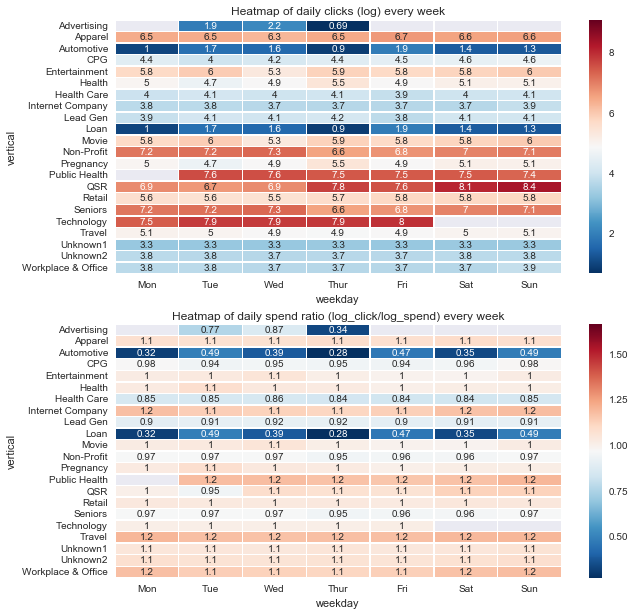

In [103]:
ver_weekday_spend_df = ver_weekday_spend_df[['Mon','Tue','Wed','Thur','Fri','Sat','Sun']]
ver_weekday_click_df = ver_weekday_click_df[['Mon','Tue','Wed','Thur','Fri','Sat','Sun']]
ver_weekday_ratio_df = ver_weekday_ratio_df[['Mon','Tue','Wed','Thur','Fri','Sat','Sun']]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#sns.heatmap(ver_mon_spend_df,annot = True, linewidths=.5, cbar = True, ax = ax1)
sns.heatmap(ver_weekday_click_df,annot = True, linewidths=.5, center = ver_weekday_click_df.mean().mean(), cbar = True, ax = ax1)
ax1.set_title('Heatmap of daily clicks (log) every week')
sns.heatmap(ver_weekday_ratio_df,annot = True, linewidths=.5, center = ver_weekday_ratio_df.mean().mean(), cbar = True, ax = ax2)
ax2.set_title('Heatmap of daily spend ratio (log_click/log_spend) every week')

**Weekly feature (between Sep and Nov)**

In [104]:
Sep_Dec_df = fb_link_df.ix[fb_link_df.month.isin(['Sep','Oct','Nov','Dec'])]

In [108]:
vert1_week_df = Sep_Dec_df.groupby(['vertical','week']).mean()
vert2_week_df = Sep_Dec_df.groupby(['vertical2','week']).mean()

vert_week_df = pd.concat([vert1_week_df,vert2_week_df], axis = 0)

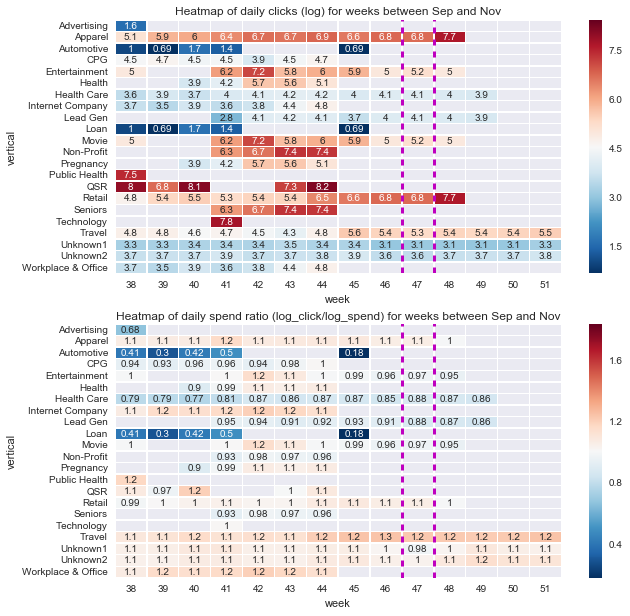

In [131]:
ver_week_spend_df = vert_week_df['log_spend'].unstack()
ver_week_click_df = vert_week_df['log_click'].unstack()
ver_week_ratio_df = ver_week_click_df/ver_week_spend_df

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#sns.heatmap(ver_mon_spend_df,annot = True, linewidths=.5, cbar = True, ax = ax1)
sns.heatmap(ver_week_click_df,annot = True, linewidths=.5, center = ver_week_click_df.mean().mean(), cbar = True, ax = ax1)
ax1.set_title('Heatmap of daily clicks (log) for weeks between Sep and Nov')
ax1.axvline(10, 0, 2, linewidth=3, c='m', linestyle = '--')
ax1.axvline(9, 0, 2, linewidth=3, c='m', linestyle = '--')
sns.heatmap(ver_week_ratio_df,annot = True, linewidths=.5, center = ver_week_ratio_df.mean().mean(), cbar = True, ax = ax2)
ax2.set_title('Heatmap of daily spend ratio (log_click/log_spend) for weeks between Sep and Nov')
ax2.axvline(10, 0, 2, linewidth=3, c='m', linestyle = '--')
ax2.axvline(9, 0, 2, linewidth=3, c='m', linestyle = '--')

In [132]:
date(2016,11,24).isocalendar()[1]

47

### 2.2.4 Model 4 : baseline + vertical + month

\begin{equation*}
log(Clicks) = m* log(spend)+b_{int}+b_{vert}+ b_{month}
\end{equation*}

In [134]:
ml_vert_mon_df = fb_link_df[['log_spend','log_click','vertical','vertical2','month']]

In [136]:
ml_vert_mon_df = pd.concat([ml_vert_mon_df, pd.get_dummies(ml_vert_mon_df.vertical,drop_first=True),pd.get_dummies(ml_vert_mon_df.vertical2,drop_first=True), pd.get_dummies(ml_vert_mon_df.month,drop_first=True)], axis = 1)

In [138]:
ml_vert_mon_df.drop(['vertical','vertical2','month'], axis = 1, inplace = True)

In [139]:
ml_vert_mon_df.head()

,log_spend,log_click,Automotive,Entertainment,Health Care,Internet Company,Non-Profit,Pregnancy,Public Health,QSR,...,Seniors,Unknown2,Workplace & Office,Dec,Jul,Jun,May,Nov,Oct,Sep
1234,5.587099,3.951244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,7.921623,6.408529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,7.666882,6.437752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
815,7.551801,6.656727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,7.431779,6.659294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
linreg_vert_mon = linear_model.LinearRegression(fit_intercept=True)  # This is the default
X_vert_mon = ml_vert_mon_df.copy()
X_vert_mon.drop('log_click', axis = 1, inplace = True)
y = ml_vert_mon_df.log_click
linreg_vert_mon.fit(X_vert_mon, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [142]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg_vert_mon.coef_[0]
print "The in-sample prediction R^2 is %.4f" % linreg_vert_mon.score(X_vert_mon,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg_vert_mon.predict(X_vert_mon))

The spend coefficients between log(spend) and log(clicks) (m) is 1.12
The in-sample prediction R^2 is 0.7382
The mean squared error in model is 0.7098


### 2.2.5 Model 4:  Time series analysis

In [144]:
# Travel campaign : 6054162669769, 6053480042769, 6053235229769
travel_camp1 = fb_link_df[fb_link_df.campaign_id == '6054162669769']# Travel
travel_camp2 = fb_link_df[fb_link_df.campaign_id == '6053235229769']
travel_camp3 = fb_link_df[fb_link_df.campaign_id == '6053480042769']

In [145]:
print travel_camp1.name.iloc[0]
print travel_camp2.name.iloc[0]
print travel_camp3.name.iloc[0]

Visit California
Visit California
Visit California


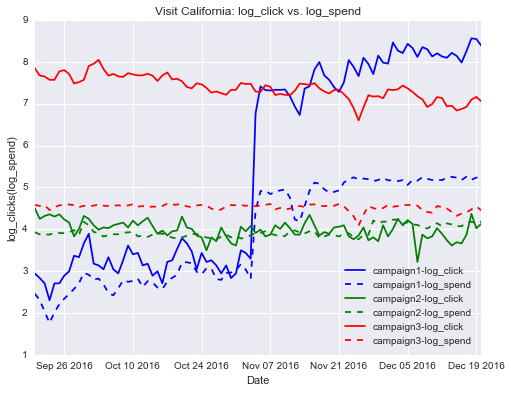

In [150]:
plt.figure(figsize=(8,6))
plt.plot(travel_camp1.date_start,travel_camp1.log_click,'b-',label = 'campaign1-log_click')
plt.plot(travel_camp1.date_start,travel_camp1.log_spend,'b--',label = 'campaign1-log_spend')
plt.plot(travel_camp2.date_start,travel_camp2.log_click,'g-',label = 'campaign2-log_click')
plt.plot(travel_camp2.date_start,travel_camp2.log_spend,'g--',label = 'campaign2-log_spend')
plt.plot(travel_camp3.date_start,travel_camp3.log_click,'r-',label = 'campaign3-log_click')
plt.plot(travel_camp3.date_start,travel_camp3.log_spend,'r--',label = 'campaign3-log_spend')

plt.xlabel('Date')
plt.ylabel('log_clicks(log_spend)')
plt.legend(loc='best')
plt.title('Visit California: log_click vs. log_spend')

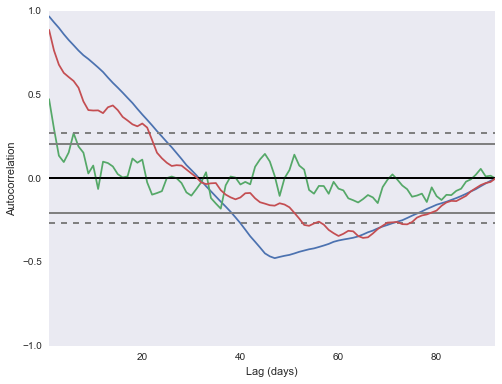

In [151]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(8,6))
autocorrelation_plot(travel_camp1['log_click'])
autocorrelation_plot(travel_camp2['log_click'])
autocorrelation_plot(travel_camp3['log_click'])
plt.xlabel('Lag (days)')

In [152]:
fb_link_df['clicks_prev'] = fb_link_df.groupby(['account_id','campaign_id'])['log_click'].shift(1).fillna(0)

In [153]:
fb_link_df.head()

,account_id,name,campaign_id,date_start,objective,vertical,vertical2,log_spend,log_click,month,weekday,week,clicks_prev
1234,1003374119710324,Line Tale 2,6042354718738,2016-04-18 00:00:00,LINK_CLICKS,Unknown1,Unknown2,5.587099,3.951244,Apr,Mon,16,0.000000
22,1003374119710324,Line Tale 2,6042354718738,2016-04-19 00:00:00,LINK_CLICKS,Unknown1,Unknown2,7.921623,6.408529,Apr,Tue,16,3.951244
60,1003374119710324,Line Tale 2,6042354718738,2016-04-20 00:00:00,LINK_CLICKS,Unknown1,Unknown2,7.666882,6.437752,Apr,Wed,16,6.408529
815,1003374119710324,Line Tale 2,6042354718738,2016-04-21 00:00:00,LINK_CLICKS,Unknown1,Unknown2,7.551801,6.656727,Apr,Thur,16,6.437752
267,1003374119710324,Line Tale 2,6042354718738,2016-04-22 00:00:00,LINK_CLICKS,Unknown1,Unknown2,7.431779,6.659294,Apr,Fri,16,6.656727


### Model 5: Time Series Model :

\begin{equation*}
log(Clicks)_{t} = m* log(spend)_{t}+ n*log(Click)_{t-1} + b_{int} + b_{vert}
\end{equation*}


In [154]:
lag1_vert_df = fb_link_df[['log_spend','log_click','vertical','vertical2','clicks_prev']]

In [155]:
lag1_vert_df = pd.concat([lag1_vert_df, pd.get_dummies(lag1_vert_df.vertical,drop_first=True),pd.get_dummies(lag1_vert_df.vertical2,drop_first=True)], axis = 1)

In [157]:
lag1_vert_df.drop(['vertical','vertical2'], axis =1, inplace = True)

In [158]:
lag1_vert_df.head()

,log_spend,log_click,clicks_prev,Automotive,Entertainment,Health Care,Internet Company,Non-Profit,Pregnancy,Public Health,...,Travel,Unknown1,CPG,Health,Lead Gen,Loan,Movie,Seniors,Unknown2,Workplace & Office
1234,5.587099,3.951244,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,7.921623,6.408529,3.951244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
60,7.666882,6.437752,6.408529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
815,7.551801,6.656727,6.437752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
267,7.431779,6.659294,6.656727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [159]:
linreg_lag1 = linear_model.LinearRegression(fit_intercept=True)  # This is the default
X_lag1 = lag1_vert_df.copy()
X_lag1.drop('log_click', axis = 1, inplace = True)
y = lag1_vert_df.log_click

In [160]:
linreg_lag1.fit(X_lag1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [162]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg_lag1.coef_[0]
print "The auto-regression coefficients (n) is %.2f" % linreg_lag1.coef_[1]
print "The in-sample prediction R^2 is %.4f" % linreg_lag1.score(X_lag1,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg_lag1.predict(X_lag1))

The spend coefficients between log(spend) and log(clicks) (m) is 0.59
The auto-regression coefficients (n) is 0.50
The in-sample prediction R^2 is 0.8590
The mean squared error in model is 0.3822


## Part 3 : Model Validation and other classifers

In [183]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

### Baseline Model :

In [185]:
X_base = fb_link_df.log_spend.reshape(-1,1)
y = fb_link_df.log_click
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_base, y, test_size=0.3)

In [186]:
RFR_base = RandomForestRegressor()# This is the default
Lin_base = linear_model.LinearRegression(fit_intercept=True)

RFR_base.fit(X_train, y_train)
Lin_base.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [187]:
print r2_score(y_test, RFR_base.predict(X_test))
print r2_score(y_test, Lin_base.predict(X_test))

0.643046670131
0.682101548934


In [188]:
print mean_squared_error(y_test, RFR_base.predict(X_test))
print mean_squared_error(y_test, Lin_base.predict(X_test))

0.962347125052
0.857055068107


### Vertical Model :

In [189]:
X_vert = ml_vert_df.copy()
X_vert.drop('log_click', axis = 1, inplace = True)
y = ml_vert_df.log_click
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vert, y, test_size=0.3)

In [190]:
RFR_vert = RandomForestRegressor()# This is the default
Lin_vert = linear_model.LinearRegression(fit_intercept=True)

RFR_vert.fit(X_train, y_train)
Lin_vert.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [191]:
print r2_score(y_test, RFR_vert.predict(X_test))
print r2_score(y_test, Lin_vert.predict(X_test))

0.74853396186
0.725096423245


In [192]:
print mean_squared_error(y_test, RFR_vert.predict(X_test))
print mean_squared_error(y_test, Lin_vert.predict(X_test))

0.666977181903
0.729141852613


### Time series + Vertical Model :

In [194]:
X_lag1 = lag1_vert_df.copy()
X_lag1.drop('log_click', axis = 1, inplace = True)
y = lag1_vert_df.log_click
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_lag1, y, test_size=0.3)

In [195]:
RFR_lag1 = RandomForestRegressor()# This is the default
Lin_lag1 = linear_model.LinearRegression(fit_intercept=True)

RFR_lag1.fit(X_train, y_train)
Lin_lag1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [196]:
print r2_score(y_test, RFR_lag1.predict(X_test))
print r2_score(y_test, Lin_lag1.predict(X_test))

0.940281892292
0.872841761109


In [197]:
print mean_squared_error(y_test, RFR_lag1.predict(X_test))
print mean_squared_error(y_test, Lin_lag1.predict(X_test))

0.172222112306
0.366713905373


In [181]:
fb_link_df.vertical.value_counts()

Unknown1            3460
Internet Company    1197
Travel              1039
Health Care          449
Retail               248
Pregnancy             54
Entertainment         52
Non-Profit            25
QSR                   17
Automotive            11
Technology            10
Public Health          6
Advertising            3
Name: vertical, dtype: int64